In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

# Download NLTK tokenizer
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sunny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
# Sample IMDB dataset (normally you'd load a real dataset)
train_data = [
    ("This movie was amazing, I loved it!", 1),
    ("I hated this movie, it was terrible.", 0),
    ("Fantastic film, brilliant acting!", 1),
    ("Worst movie ever, don't waste your time.", 0),
    ("Great story and well directed!", 1),
    ("Awful film, I regret watching it.", 0),
]

test_data = [
    ("I really enjoyed this film!", 1),
    ("The movie was bad and boring.", 0),
]


In [14]:
# Tokenization
def tokenize(text):
    return word_tokenize(text.lower())  # Convert to lowercase & tokenize

# Build Vocabulary
all_text = [tokenize(text) for text, _ in train_data]
unique_words = set(word for sentence in all_text for word in sentence)
word_to_index = {word: i+1 for i, word in enumerate(unique_words)}  # Word to index mapping
word_to_index["<PAD>"] = 0  # Padding token


In [15]:
# Convert text to numerical tensors
def text_to_tensor(text, max_length=10):
    tokenized = tokenize(text)
    indexed = [word_to_index.get(word, 0) for word in tokenized]  # Convert words to indices
    if len(indexed) < max_length:
        indexed += [0] * (max_length - len(indexed))  # Padding
    return torch.tensor(indexed[:max_length], dtype=torch.long)


In [16]:
# Convert labels to tensors
def label_to_tensor(label):
    return torch.tensor(label, dtype=torch.float32)


In [17]:
# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text, label = self.data[idx]
        return text_to_tensor(text), label_to_tensor(label)



In [18]:
# Create Dataset & DataLoader
train_dataset = SentimentDataset(train_data)
test_dataset = SentimentDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2)


In [19]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)  # Embedding layer
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)  # Simple RNN layer
        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)  # RNN output and last hidden state
        return torch.sigmoid(self.fc(hidden.squeeze(0)))  # Apply sigmoid for binary classification

# Initialize Model
vocab_size = len(word_to_index)
embed_dim = 50
hidden_dim = 128
output_dim = 1

model = RNNModel(vocab_size, embed_dim, hidden_dim, output_dim)


In [20]:
# Loss function & optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for text, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(text).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}')


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 49.07it/s]


Epoch 1, Loss: 0.7039


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 166.63it/s]


Epoch 2, Loss: 0.5810


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 179.98it/s]


Epoch 3, Loss: 0.4685


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 147.17it/s]


Epoch 4, Loss: 0.3489


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 147.08it/s]


Epoch 5, Loss: 0.2436


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 142.75it/s]


Epoch 6, Loss: 0.1542


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 172.19it/s]


Epoch 7, Loss: 0.0903


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.94it/s]


Epoch 8, Loss: 0.0530


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 144.59it/s]


Epoch 9, Loss: 0.0298


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 138.29it/s]

Epoch 10, Loss: 0.0191


In [21]:
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for text, labels in test_loader:
            outputs = model(text).squeeze()
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total

accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.5000


In [22]:
def predict_sentiment(text):
    model.eval()
    with torch.no_grad():
        text_tensor = text_to_tensor(text).unsqueeze(0)
        output = model(text_tensor).item()
        return "Positive" if output > 0.5 else "Negative"

print(predict_sentiment("I absolutely loved this film!"))
print(predict_sentiment("The worst movie I have ever seen."))


Positive
Negative


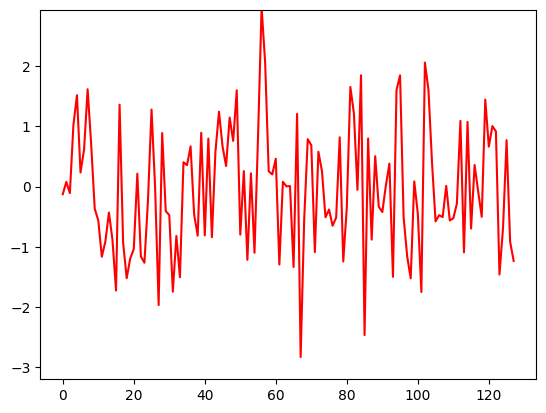

In [24]:
import matplotlib.animation as animation

# Generate random hidden states for visualization
time_steps = 20
hidden_states = np.random.randn(time_steps, hidden_dim)

fig, ax = plt.subplots()
line, = ax.plot(hidden_states[0], 'r')

def update(num):
    line.set_ydata(hidden_states[num])
    return line,

ani = animation.FuncAnimation(fig, update, frames=range(time_steps), interval=200)
ani.save("rnn-model.gif", writer = 'pillow', fps = 5)
plt.show()